In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
tulu_data = pd.read_csv("tulu_train.csv").replace(".", "asterisk").fillna("")
tulu_val = pd.read_csv("tulu_val.csv").replace(".", "asterisk").fillna("")

kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)


# Oversampling "mixed", "kannada" and "other" categories to improve accuracy of those categories
tulu_mixed = tulu_data[tulu_data["Language"] == "Mixed"]
tulu_kan = tulu_data[tulu_data["Language"] == "Kannada"]
tulu_other = tulu_data[tulu_data["Language"] == "Other"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
tamil_name["Tag"] = tamil_name["Tag"].replace("name", "Name")
tamil_name.columns = ["Words", "Language"]
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
kanada_name["Tag"] = kanada_name["Tag"].replace("name", "Name")
kanada_name.columns = ["Words", "Language"]
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]
malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "Name")
malayalam_name.columns = ["Words", "Language"]

# Location from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
tamil_loc.columns = ["Words", "Language"]
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
kanada_loc["Tag"] = kanada_loc["Tag"].replace("location", "Location")
kanada_loc.columns = ["Words", "Language"]
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]
malayalam_loc["Tag"] = malayalam_loc["Tag"].replace("PLACE", "Location")
malayalam_loc.columns = ["Words", "Language"]

# Combining all the data needed for training
tulu_data = pd.concat([tulu_data, tulu_mixed, kanada_loc, tulu_loc, tulu_mixed, kanada_name, tulu_other, tulu_mixed, tulu_name, tulu_loc, tulu_other, tulu_mixed, tulu_loc, tulu_name, tamil_loc, tulu_kan, tulu_other, malayalam_loc, tulu_mixed, tulu_other]).fillna("")
tulu_data_with_val = pd.concat([tulu_data, tulu_val])

C:\Users\justa\AppData\Local\Temp\ipykernel_20420\671579527.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tamil_name["Tag"] = tamil_name["Tag"].replace("name", "Name")
C:\Users\justa\AppData\Local\Temp\ipykernel_20420\671579527.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kanada_name["Tag"] = kanada_name["Tag"].replace("name", "Name")
C:\Users\justa\AppData\Local\Temp\ipykernel_20420\671579527.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [3]:
tulu_data["Language"].value_counts()

Language
Tulu        11649
English      7480
Kannada      5900
Name         5884
sym          4243
Mixed        3258
Other        3190
Location     2344
Name: count, dtype: int64

In [4]:
tulu_data_with_val["Language"].value_counts()

Language
Tulu        12900
English      8222
Kannada      6173
Name         6019
sym          4665
Mixed        3315
Other        3275
Location     2385
Name: count, dtype: int64

<Axes: xlabel='Language', ylabel='Count'>

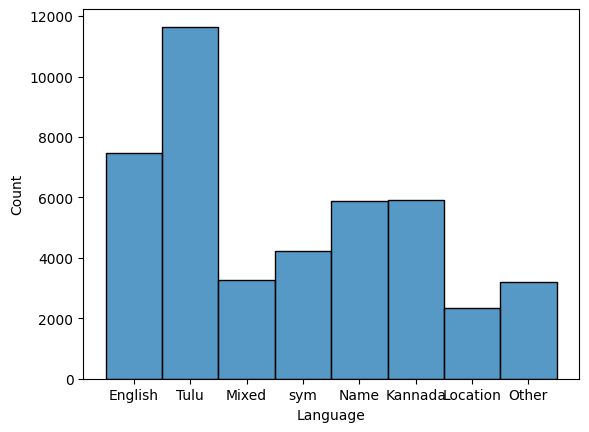

In [5]:
sb.histplot(tulu_data["Language"])

In [6]:
tulu_data.describe()

,Words,Language
count,43948,43948
unique,10381,8
top,asterisk,Tulu
freq,4243,11649


In [7]:
tulu_val.describe()

,Words,Language
count,3006,3006
unique,1688,8
top,asterisk,Tulu
freq,422,1251


In [8]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf = TfidfVectorizer(ngram_range=(1,5),analyzer='char')
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = MultinomialNB()
model2 = MultinomialNB()

model3 = LogisticRegression(solver='newton-cg', max_iter=2000)
model4 = LogisticRegression(solver='newton-cg', max_iter=2000)

model5 = svm.SVC()
model6 = svm.SVC()

model8 = DecisionTreeClassifier(random_state=42)
model9 = DecisionTreeClassifier(random_state=42)

model7 = VotingClassifier(
    estimators=[
        ('dtc', model8), 
        ('lr', model3), 
        ('svm', model5),
    ],
    voting='hard'
)

acc = [[], [], [], [], [], [], [], []] 
f1 = [[], [], [], [], [], [], [], []]
pre = [[], [], [], [], [], [], [], []]
rec = [[], [], [], [], [], [], [], []]

f1_a = [[], [], [], [], [], [], [], []]

In [8]:
X = tulu_data_with_val["Words"]
Y = tulu_data_with_val["Language"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    train_vect_tf = tfidf.fit_transform(X_train)
    test_vect_tf = tfidf.transform(X_test)


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
    model2.fit(train_vect_tf, y_train)
    model2_predict = model2.predict(test_vect_tf)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using COUNT VECTORIZATION
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using TFIDF VECTORIZATION
    model4.fit(train_vect_tf, y_train)
    model4_predict = model4.predict(test_vect_tf)

    acc[3].append(accuracy_score(y_test, model4_predict))
    f1[3].append(f1_score(y_test, model4_predict, average="macro"))
    f1_a[3].append(f1_score(y_test, model4_predict, average="weighted"))
    pre[3].append(precision_score(y_test, model4_predict, average="macro", zero_division=np.nan))
    rec[3].append(recall_score(y_test, model4_predict, average="macro", zero_division=np.nan))

    # SVM using COUNT VECTORIZATION
    model5.fit(train_vect_count, y_train)
    model5_predict = model5.predict(test_vect_count)

    acc[4].append(accuracy_score(y_test, model5_predict))
    f1[4].append(f1_score(y_test, model5_predict, average="macro"))
    f1_a[4].append(f1_score(y_test, model5_predict, average="weighted"))
    pre[4].append(precision_score(y_test, model5_predict, average="macro", zero_division=np.nan))
    rec[4].append(recall_score(y_test, model5_predict, average="macro", zero_division=np.nan))

    # SVM using TFIDF VECTORIZATION
    model6.fit(train_vect_tf, y_train)
    model6_predict = model6.predict(test_vect_tf)

    acc[5].append(accuracy_score(y_test, model6_predict))
    f1[5].append(f1_score(y_test, model6_predict, average="macro"))
    f1_a[5].append(f1_score(y_test, model6_predict, average="weighted"))
    pre[5].append(precision_score(y_test, model6_predict, average="macro", zero_division=np.nan))
    rec[5].append(recall_score(y_test, model6_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using COUNT VECTORIZATION
    model8.fit(train_vect_count, y_train)
    model8_predict = model8.predict(test_vect_count)

    acc[6].append(accuracy_score(y_test, model8_predict))
    f1[6].append(f1_score(y_test, model8_predict, average="macro"))
    f1_a[6].append(f1_score(y_test, model8_predict, average="weighted"))
    pre[6].append(precision_score(y_test, model8_predict, average="macro", zero_division=np.nan))
    rec[6].append(recall_score(y_test, model8_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using TFIDF VECTORIZATION
    model9.fit(train_vect_tf, y_train)
    model9_predict = model9.predict(test_vect_tf)

    acc[7].append(accuracy_score(y_test, model9_predict))
    f1[7].append(f1_score(y_test, model9_predict, average="macro"))
    f1_a[7].append(f1_score(y_test, model9_predict, average="weighted"))
    pre[7].append(precision_score(y_test, model9_predict, average="macro", zero_division=np.nan))
    rec[7].append(recall_score(y_test, model9_predict, average="macro", zero_division=np.nan))

In [9]:
MNB_count = ["MultinomialNB (Count)",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
MNB_tf = ["MultinomialNB (TFIDF)", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
Logistic_count = ["Logistic (Count)",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]
Logistic_tf = ["Logistic (TFIDF)", sum(acc[3])/len(acc[3]), sum(f1[3])/len(f1[3]), sum(f1_a[3])/len(f1_a[3]), sum(pre[3])/len(pre[3]), sum(rec[3])/len(rec[3])]
SVM_count = ["SVM (Count)", sum(acc[4])/len(acc[4]), sum(f1[4])/len(f1[4]), sum(f1_a[4])/len(f1_a[4]), sum(pre[4])/len(pre[4]), sum(rec[4])/len(rec[4])]
SVM_tf = ["SVM (TFIDF)", sum(acc[5])/len(acc[5]), sum(f1[5])/len(f1[5]), sum(f1_a[5])/len(f1_a[5]), sum(pre[5])/len(pre[5]), sum(rec[5])/len(rec[5])]
DTC_count = ["DTC (Count)", sum(acc[6])/len(acc[6]), sum(f1[6])/len(f1[6]), sum(f1_a[6])/len(f1_a[6]), sum(pre[6])/len(pre[6]), sum(rec[6])/len(rec[6])]
DTC_tf = ["DTC (Count)", sum(acc[7])/len(acc[7]), sum(f1[7])/len(f1[7]), sum(f1_a[7])/len(f1_a[7]), sum(pre[7])/len(pre[7]), sum(rec[7])/len(rec[7])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([MNB_count, MNB_tf, Logistic_count, Logistic_tf, SVM_count, SVM_tf, DTC_count, DTC_tf])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
MultinomialNB (Count),0.8271925124230533,0.8305091001105589,0.8271671937005614,0.8280829478749346,0.8366414405527859
MultinomialNB (TFIDF),0.8258082785884436,0.8216076163310682,0.823494152042009,0.8727305529193558,0.7918873444482546
Logistic (Count),0.9282062045417849,0.935366856841851,0.9281446552813408,0.932776631528424,0.9381715342194414
Logistic (TFIDF),0.9000085224231803,0.9061685719878426,0.8999582573580869,0.9139258826303396,0.8992340921601301
SVM (Count),0.9144054804759858,0.9230722980196171,0.9142453535096686,0.9282460023261063,0.9185957295385878
SVM (TFIDF),0.9329342489835684,0.9405393910892036,0.9329764834872101,0.9402884181081145,0.9409822487878655
DTC (Count),0.919964150488123,0.9293816186412414,0.9199780477644053,0.9223008256056016,0.9374130925957553
DTC (Count),0.9163648213964981,0.9260387745953524,0.9163227821272331,0.9181877307324193,0.9349674147221162


In [9]:
x_train = tulu_data["Words"]
y_train = tulu_data["Language"]
x_test = tulu_val["Words"]
y_test = tulu_val["Language"]

count_vec_train = countVectorizer.fit_transform(x_train)
tf_vec_train = tfidf.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)
tf_vec_test = tfidf.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

model7.fit(tf_vec_train, y_train)
model7_predict = model7.predict(tf_vec_test)

print(classification_report(y_test, model7_predict), "\n")

              precision    recall  f1-score   support

     English       0.91      0.94      0.92       742
     Kannada       0.73      0.77      0.75       273
    Location       0.82      0.90      0.86        41
       Mixed       0.81      0.68      0.74        57
        Name       0.79      0.81      0.80       135
       Other       0.65      0.58      0.61        85
        Tulu       0.92      0.90      0.91      1251
         sym       1.00      1.00      1.00       422

    accuracy                           0.90      3006
   macro avg       0.83      0.82      0.83      3006
weighted avg       0.90      0.90      0.90      3006
 

              precision    recall  f1-score   support

     English       0.91      0.93      0.92       742
     Kannada       0.74      0.76      0.75       273
    Location       0.82      0.90      0.86        41
       Mixed       0.81      0.61      0.70        57
        Name       0.80      0.79      0.80       135
       Other       0.6

In [11]:
# result = pd.concat([x_test.reset_index(drop=True), pd.Series(model7_predict, name="Tag")], axis=1).replace("asterisk",".")
# result.to_csv('predictions.csv', index=False)

In [13]:
X_train = tulu_data["Words"]
y_train = tulu_data["Language"]

X_test = tulu_val["Words"]
y_test = tulu_val["Language"]

train_vect_count = countVectorizer.fit_transform(X_train)
test_vect_count = countVectorizer.transform(X_test)

train_vect_tf = tfidf.fit_transform(X_train)
test_vect_tf = tfidf.transform(X_test)


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
model1.fit(train_vect_count, y_train)
model1_predict = model1.predict(test_vect_count)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION")
print(classification_report(y_test, model1_predict), "\n\n")


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
model2.fit(train_vect_tf, y_train)
model2_predict = model2.predict(test_vect_tf)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION")
print(classification_report(y_test, model2_predict), "\n\n")


# LOGISTIC REGRESSION using COUNT VECTORIZATION
model3.fit(train_vect_count, y_train)
model3_predict = model3.predict(test_vect_count)
print("LOGISTIC REGRESSION using COUNT VECTORIZATION")
print(classification_report(y_test, model3_predict), "\n\n")


# LOGISTIC REGRESSION using TFIDF VECTORIZATION
model4.fit(train_vect_tf, y_train)
model4_predict = model4.predict(test_vect_tf)
print("LOGISTIC REGRESSION using TFIDF VECTORIZATION")
print(classification_report(y_test, model4_predict), "\n\n")

# SVM using COUNT VECTORIZATION
model5.fit(train_vect_count, y_train)
model5_predict = model5.predict(test_vect_count)
print("SVM using COUNT VECTORIZATION")
print(classification_report(y_test, model5_predict), "\n\n")

# SVM using TFIDF VECTORIZATION
model6.fit(train_vect_tf, y_train)
model6_predict = model6.predict(test_vect_tf)
print("SVM using TFIDF VECTORIZATION")
print(classification_report(y_test, model6_predict), "\n\n")

# Decision Tree Classifier using COUNT VECTORIZATION
model8.fit(train_vect_count, y_train)
model8_predict = model8.predict(test_vect_count)
print("Decision Tree Classifier using COUNT VECTORIZATION")
print(classification_report(y_test, model8_predict), "\n\n")

# Decision Tree Classifier using TFIDF VECTORIZATION
model9.fit(train_vect_tf, y_train)
model9_predict = model9.predict(test_vect_tf)
print("Decision Tree Classifier using TFIDF VECTORIZATION")
print(classification_report(y_test, model9_predict))

MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
              precision    recall  f1-score   support

     English       0.91      0.74      0.81       742
     Kannada       0.54      0.75      0.63       273
    Location       0.52      0.93      0.67        41
       Mixed       0.32      0.67      0.43        57
        Name       0.59      0.73      0.65       135
       Other       0.47      0.51      0.49        85
        Tulu       0.89      0.82      0.85      1251
         sym       0.98      1.00      0.99       422

    accuracy                           0.80      3006
   macro avg       0.65      0.77      0.69      3006
weighted avg       0.84      0.80      0.81      3006
 


MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

     English       0.92      0.80      0.86       742
     Kannada       0.67      0.68      0.68       273
    Location       0.80      0.88      0.84        41